Training XGBoost...
Training Random Forest...
XGBoost MSE: 44225923.10685378
Random Forest MSE: 35540867.17030659


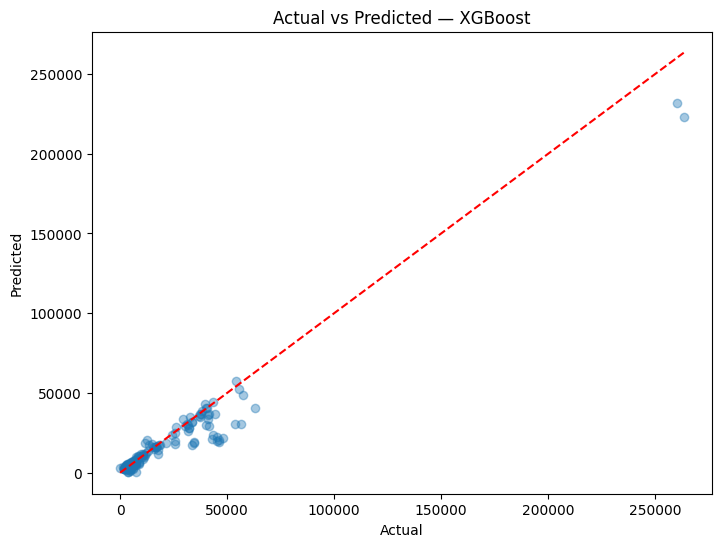

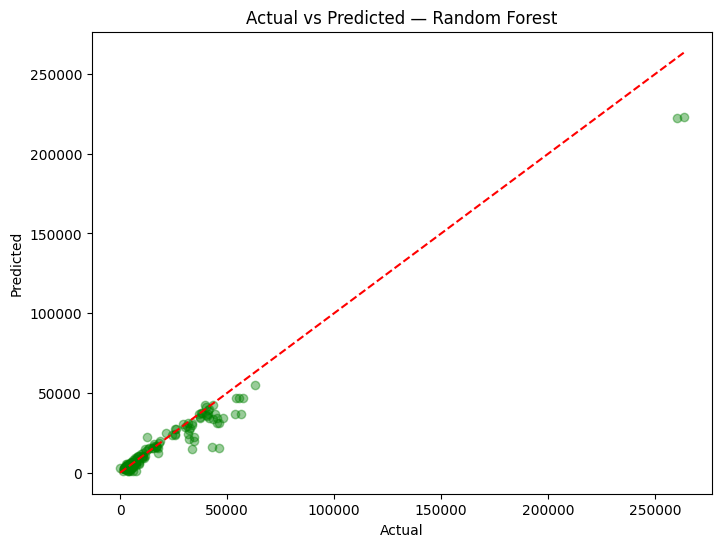

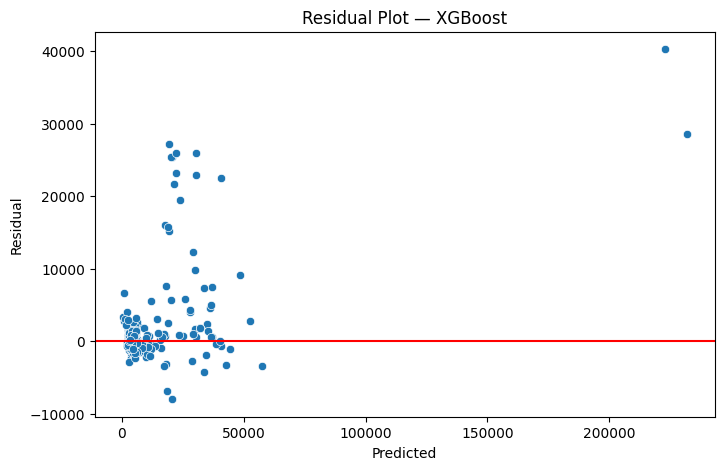

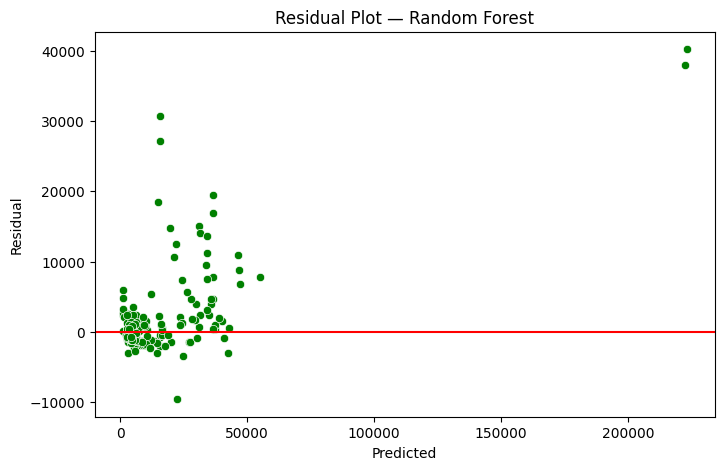

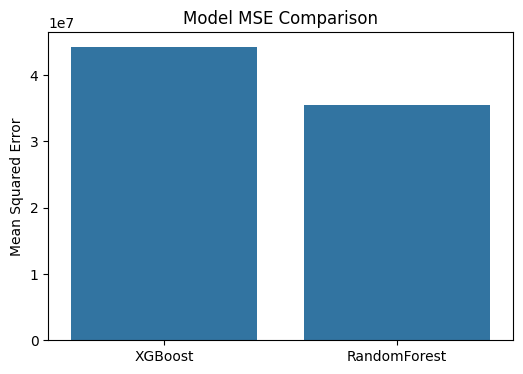

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

# ----------------------------------------
# LOAD DATA
# ----------------------------------------
df = pd.read_csv("aiml.csv", encoding="latin1")

# ----------------------------------------
# CLEAN TARGET COLUMN
# ----------------------------------------
df["Impressions"] = pd.to_numeric(df["Impressions"], errors="coerce")
df["Impressions"] = df["Impressions"].replace([np.inf, -np.inf], np.nan)
df.dropna(subset=["Impressions"], inplace=True)

# LOG TRANSFORM TARGET
df["Log_Impressions"] = np.log1p(df["Impressions"])

# ----------------------------------------
# CLEAN TEXT
# ----------------------------------------
df["Caption"] = df["Caption"].astype(str).fillna("")
df["Topic"] = df["Topic"].astype(str).fillna("")
df["Text"] = df["Caption"] + " " + df["Topic"]
df = df.drop(columns=["Caption", "Topic"])

# ----------------------------------------
# FEATURES
# ----------------------------------------
y = df["Log_Impressions"]
X = df.drop(columns=["Impressions", "Log_Impressions"])

numeric_cols = [
    "From Home","From Hashtags","From Explore","From Other",
    "Saves","Comments","Shares","Likes","Profile Visits","Follows"
]

# ----------------------------------------
# TRAIN–TEST SPLIT
# ----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# ----------------------------------------
# PREPROCESSOR (IMPUTE + SCALE + TFIDF)
# ----------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler())
        ]), numeric_cols),

        ("text", TfidfVectorizer(max_features=5000, ngram_range=(1,2)), "Text")
    ],
    remainder="drop"
)

# ----------------------------------------
# MODELS
# ----------------------------------------
xgb_model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    eval_metric="rmse"
)

rf_model = RandomForestRegressor(
    n_estimators=400,
    random_state=42
)

# ----------------------------------------
# PIPELINES
# ----------------------------------------
xgb_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", xgb_model)
])

rf_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", rf_model)
])

# ----------------------------------------
# TRAIN BOTH MODELS
# ----------------------------------------
print("Training XGBoost...")
xgb_pipe.fit(X_train, y_train)

print("Training Random Forest...")
rf_pipe.fit(X_train, y_train)

# ----------------------------------------
# PREDICTIONS
# ----------------------------------------
y_pred_log_xgb = xgb_pipe.predict(X_test)
y_pred_log_rf = rf_pipe.predict(X_test)

y_pred_xgb = np.expm1(y_pred_log_xgb)
y_pred_rf = np.expm1(y_pred_log_rf)
y_test_real = np.expm1(y_test)

# ----------------------------------------
# MSE RESULTS
# ----------------------------------------
mse_xgb = mean_squared_error(y_test_real, y_pred_xgb)
mse_rf  = mean_squared_error(y_test_real, y_pred_rf)

print("XGBoost MSE:", mse_xgb)
print("Random Forest MSE:", mse_rf)

# ----------------------------------------
# GRAPHS
# ----------------------------------------

# ---------- 1. Actual vs Predicted (XGB) -----------
plt.figure(figsize=(8,6))
plt.scatter(y_test_real, y_pred_xgb, alpha=0.4)
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()], "r--")
plt.title("Actual vs Predicted — XGBoost")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# ---------- 2. Actual vs Predicted (RF) -----------
plt.figure(figsize=(8,6))
plt.scatter(y_test_real, y_pred_rf, alpha=0.4, color='green')
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()], "r--")
plt.title("Actual vs Predicted — Random Forest")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# ---------- 3. Residual Plot (XGB) -----------
residuals_xgb = y_test_real - y_pred_xgb
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_xgb, y=residuals_xgb)
plt.axhline(0, color="red")
plt.title("Residual Plot — XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()

# ---------- 4. Residual Plot (RF) -----------
residuals_rf = y_test_real - y_pred_rf
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_rf, y=residuals_rf, color="green")
plt.axhline(0, color="red")
plt.title("Residual Plot — Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()

# ---------- 5. Error Comparison Bar Chart -----------
plt.figure(figsize=(6,4))
sns.barplot(x=["XGBoost","RandomForest"], y=[mse_xgb,mse_rf])
plt.title("Model MSE Comparison")
plt.ylabel("Mean Squared Error")
plt.show()


In [46]:
def predict_impressions(
        from_home, from_hashtags, from_explore, from_other,
        saves, comments, shares, likes, profile_visits, follows,
        caption, topic
    ):

    # Combine caption + topic just like old pipeline
    text = str(caption) + " " + str(topic)

    new_data = pd.DataFrame([{
        "From Home": from_home,
        "From Hashtags": from_hashtags,
        "From Explore": from_explore,
        "From Other": from_other,
        "Saves": saves,
        "Comments": comments,
        "Shares": shares,
        "Likes": likes,
        "Profile Visits": profile_visits,
        "Follows": follows,
        "Text": text
    }])

    pred_log = pipe.predict(new_data)[0]
    pred = np.expm1(pred_log)
    return pred


In [49]:
pred = predict_impressions(
    from_home=150000,         # A lot of home impressions
    from_hashtags=35000,
    from_explore=80000,
    from_other=5000,

    saves=10000,              # Very high saves
    comments=8000,            # Very high comments
    shares=3000,
    likes=75000,              # 🔥 VERY HIGH LIKE COUNT
    profile_visits=20000,
    follows=5000,

    caption="This post blew up instantly! 🔥🔥 Thanks for the crazy support!",
    topic="Viral Trending Content"
)

print("Predicted Impressions:", pred)


Predicted Impressions: 220329.95
